<a href="https://colab.research.google.com/github/Requiem5032/mcs-applied-ai/blob/main/autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup environment

In [1]:
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [2]:
# import condacolab
# condacolab.check()

In [3]:
# !mamba install -q pytorch torchvision torchaudio pytorch-cuda=12.4 -c pytorch -c nvidia

In [4]:
# !mamba install -q numpy pandas matplotlib scikit-learn ipython

# Setup GPU

In [5]:
# Remember to switch runtime if using google collab

import torch
torch.__version__

'2.5.1+cu121'

In [6]:
torch.cuda.is_available()

True

In [7]:
dev_index = torch.cuda.current_device()
dev_index

0

In [8]:
torch.cuda.get_device_name(dev_index)

'Tesla T4'

In [9]:
device = torch.device(f'cuda:{dev_index}')
device

device(type='cuda', index=0)

# Setup dataset

In [10]:
import torchvision
import torchvision.transforms as transforms

In [11]:
batch_size = 256
num_workers = 2

In [12]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))],
  )

In [40]:
train_ds = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform,
)

valid_ds = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform,
)

In [41]:
train_dl = torch.utils.data.DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

valid_dl = torch.utils.data.DataLoader(
    valid_ds,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

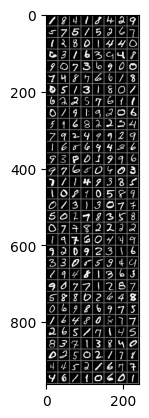

In [15]:
import matplotlib.pyplot as plt
import numpy as np


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

data_iter = iter(train_dl)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images))

# Setup autoencoder

In [20]:
import torch.nn as nn

In [21]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(1, 64, 4, 2 ,1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(64, 64*2, 4, 2 ,1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Flatten(),
        nn.Linear((64*2) * 7*7, 7)
    )

  def forward(self, inp):
    return self.main(inp)

In [22]:
class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.linear = nn.Linear(7, (64*2) * 7*7)
    self.main = nn.Sequential(
        nn.ConvTranspose2d(64*2, 64, 4, 2, 1, bias=False),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, inp):
    x = self.linear(inp)
    x = x.view((-1, 64*2, 7, 7))
    out = self.main(x)
    return out

In [24]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()

  def forward(self, inp):
    x = self.encoder(inp)
    out = self.decoder(x)
    return out

# Train autoencoder

In [33]:
def train(mode, criterion, optimizer, epochs, train_dl):
  model.train()

  for epoch in range(epochs):
    for i, data in enumerate(train_dl):
      model.zero_grad()
      inp = data[0].to(device)
      out = model(inp).view(-1)

      loss = criterion(out.view(-1, 1, 28, 28), inp)
      loss.backward()
      optimizer.step()

    print('[%d/%d]\tLoss: %.4f' % (epoch + 1, epochs, loss.item()))
    torch.save(model.state_dict(), './autoencoder.pth')


In [34]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20

In [35]:
train(model, criterion, optimizer, epochs, train_dl)

[1/20]	Loss: 0.1083
[2/20]	Loss: 0.0902
[3/20]	Loss: 0.0852
[4/20]	Loss: 0.0858
[5/20]	Loss: 0.0874
[6/20]	Loss: 0.0796
[7/20]	Loss: 0.0767
[8/20]	Loss: 0.0773
[9/20]	Loss: 0.0804
[10/20]	Loss: 0.0789
[11/20]	Loss: 0.0799
[12/20]	Loss: 0.0725
[13/20]	Loss: 0.0768
[14/20]	Loss: 0.0647
[15/20]	Loss: 0.0820
[16/20]	Loss: 0.0787
[17/20]	Loss: 0.0729
[18/20]	Loss: 0.0721
[19/20]	Loss: 0.0729
[20/20]	Loss: 0.0694


In [44]:
images, _ = next(iter(valid_dl))
out = model(images.to(device))

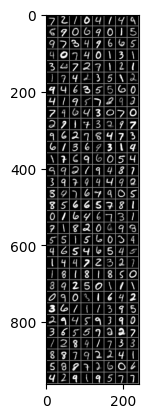

In [46]:
imshow(torchvision.utils.make_grid(out.cpu()))